In [38]:
import pandas as pd
import numpy as np

## encode functions
##### main custom functions
def one_hot_encode(df,columns_for_one_hot):
    '''One hot encode the columns for feeding into the model
    :df: Dataframe of the data
    :columns_for_one_hot: array name of columns to input
    :return: Dataframe of the one hot encoded data with prefix = columns_for_one_hot
    '''
#     for col_index in columns_for_one_hot:
#         df[col_index]=df[col_index].replace(['0',0], 'No_{}'.format(col_index))
    ## one hot encode
    for column_for_one_hot in columns_for_one_hot:
        #  Get one hot encoding of columns B
        one_hot = pd.get_dummies(df[column_for_one_hot],prefix=column_for_one_hot)
        # Drop column B as it is now encoded
        df = df.drop(column_for_one_hot,axis = 1)
        # Join the encoded df
        df = df.join(one_hot,rsuffix=column_for_one_hot)
    return df
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import median_absolute_error

def evaluate(y_pred,Y_val):
    f1_sep=round(f1_score(Y_val, y_pred,average='micro'),6)
    print('f1_score is:', str(f1_sep))
    acc_sep=round(accuracy_score(Y_val, y_pred),6)
    print('accuracy_score is:', str(acc_sep))

In [39]:
## read and encode data
dfg = pd.read_csv(
    './vintage_wine_description_processed.csv',index_col=0).fillna(0)
to_encode=['country','province','region_1','region_2','variety','area']
to_drop=['designation','description','title','Location_description','location','winery','price','points']
dfg=dfg.drop(to_drop,axis=1)
dfg=one_hot_encode(dfg,to_encode)
dfg.head()

,year,temp1,temp10,temp11,temp12,temp13,temp14,temp15,temp16,temp17,...,area_Eastern France,area_Jura,area_Languedoc,area_Languedoc-Roussillon,area_Loire,area_Lyonnais,area_Provence,area_Rhône,area_Savoy,area_South West France
0,2013,11.390,20.302,16.792,12.432,11.375,9.663,13.650,15.543,17.691,...,0,0,0,0,0,0,1,0,0,0
1,2011,4.690,12.437,7.362,4.967,5.142,6.502,8.337,14.164,16.951,...,0,0,0,0,1,0,0,0,0,0
2,2013,4.350,11.176,7.606,3.811,2.580,4.904,7.617,9.347,12.848,...,0,0,0,0,0,0,0,0,0,0
3,2013,-1.763,10.034,3.674,1.283,-2.770,-4.096,-0.363,6.836,16.905,...,0,0,0,0,0,0,0,0,0,0
4,2012,4.761,10.858,5.631,2.999,4.350,4.755,5.160,9.238,11.430,...,0,0,0,0,0,0,0,0,0,0


In [40]:
## convert to categorical data
for column_name in list(dfg.filter(regex='^(?:taste)').columns):
    dfg[column_name]=pd.Categorical(dfg[column_name].apply(lambda x: 1 if x>0 else 0))

In [55]:
### split xy and filter out columns that are not needed
y_col=list(dfg.filter(regex='^(?:taste)').columns)
# print(y_col)
# regex_out_taste='^(?!taste)'
X = dfg.drop(y_col, axis=1) # Training & Validation data
Y = dfg[y_col]              # Response / Target Variable


# pass data through PCA model
from sklearn import decomposition
pca = decomposition.PCA(n_components=34)
X = pca.fit_transform(X)


### normalize data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
# Y=scaler.fit_transform(Y)
# print(Y)

print(X.shape, Y.shape)

# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation 

np.random.seed(5875) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = \
                train_test_split(X, Y, test_size=0.1)

print('Training Samples:', X_train.shape, Y_train.shape)
print('Validation Samples:', X_val.shape, Y_val.shape)


(125345, 34) (125345, 98)
Training Samples: (112810, 34) (112810, 98)
Validation Samples: (12535, 34) (12535, 98)


In [61]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
lgbm = LGBMClassifier()           # create
lgbm_regr= MultiOutputClassifier(lgbm)
lgbm_regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=lgbm_regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.272506
accuracy_score is: 8e-05


In [90]:
import seaborn as sb
# pd.DataFrame(Y_val.columns,y_pred)
pred_df=pd.DataFrame(y_pred[0:20])
pred_df.columns=Y_val.columns
pred_df
# sb.countplot(pred_df.iloc[3])
# sb.countplot(pred_df)
# sb.scatterplot
Y_val

,taste_aroma,taste_fruit,taste_herb,taste_palat,taste_offer,taste_appl,taste_citru,taste_acid,taste_ripe,taste_fruiti,...,taste_long,taste_fine,taste_creami,taste_medium,taste_dens,taste_make,taste_complex,taste_power,taste_delici,taste_also
19729,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
67534,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
87476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88677,1,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
9286,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
94444,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25260,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
126646,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
118860,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
83543,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
logreg = LogisticRegression(solver='newton-cg')           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))


f1_score is: 0.157441
accuracy_score is: 0.000145


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
logreg = RandomForestClassifier(n_estimators=10,verbose=1)           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

f1_score is: 0.229759
accuracy_score is: 0.000363


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
logreg = KNeighborsClassifier()           # create
regr= MultiOutputClassifier(logreg,6)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.22877
accuracy_score is: 4e-05


In [46]:
from sklearn.neighbors import KNeighborsClassifier        # create
regr= KNeighborsClassifier()
regr.fit(X_train, Y_train.iloc[:,1].astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.iloc[:,1].astype('int'))

f1_score is: 0.610209
accuracy_score is: 0.610209


In [47]:
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.multioutput import MultiOutputClassifier
logreg = GaussianNB()           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.281375
accuracy_score is: 8e-06


In [48]:
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
logreg = Perceptron()           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.230616
accuracy_score is: 0.0


In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
logreg = DecisionTreeClassifier()           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.245948
accuracy_score is: 0.001346


In [58]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
logreg = SVC()           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/

/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/

/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/

/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learnai/lib/python3.6/site-packages/

f1_score is: 0.167129
accuracy_score is: 0.0


In [60]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
regr= MultiOutputClassifier(gbm)
regr.fit(X_train, Y_train.astype('int'))
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.243039
accuracy_score is: 8e-05


In [59]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
logreg = LinearSVC()           # create
regr= MultiOutputClassifier(logreg)
regr.fit(X_train, Y_train.astype('int'))            # train
y_pred=regr.predict(X_val)
evaluate(y_pred,Y_val.astype('int'))

f1_score is: 0.186769
accuracy_score is: 0.0


In [56]:
## neural network
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(1000,input_shape=[34,],activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(98,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=100,epochs=10,verbose=1)

_,acc = model.evaluate(X_val,Y_val,verbose=0)
print('Accuracy',np.round(acc*100),'%')
y_pred=model.predict(X_val)
evaluate(y_pred.round(),Y_val.astype('int'))

Epoch 1/10
112810/112810 [==============================] - 25s 223us/step - loss: 40.2032 - acc: 0.2459
Epoch 2/10
112810/112810 [==============================] - 24s 213us/step - loss: 39.4303 - acc: 0.2461
Epoch 3/10
112810/112810 [==============================] - 25s 219us/step - loss: 39.1765 - acc: 0.2531
Epoch 4/10
112810/112810 [==============================] - 25s 219us/step - loss: 39.0222 - acc: 0.2547
Epoch 5/10
112810/112810 [==============================] - 24s 213us/step - loss: 38.9163 - acc: 0.2515
Epoch 6/10
112810/112810 [==============================] - 27s 243us/step - loss: 38.8342 - acc: 0.2502
Epoch 7/10
112810/112810 [==============================] - 24s 216us/step - loss: 38.7713 - acc: 0.2495
Epoch 8/10
112810/112810 [==============================] - 23s 200us/step - loss: 38.7199 - acc: 0.2470
Epoch 9/10
112810/112810 [==============================] - 1233s 11ms/step - loss: 38.6776 - acc: 0.2462
Epoch 10/10
112810/112810 [===========================

/anaconda3/envs/learnai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
y_nn_pred=model.predict(X_val)
pd.DataFrame(y_nn_pred)
# evaluate(y_pred,Y_val.astype('int'))


f1_score is: 0.22877
accuracy_score is: 4e-05


In [7]:
Y_train.iloc[:,0:10]

,taste_aroma,taste_fruit,taste_herb,taste_palat,taste_offer,taste_appl,taste_citru,taste_acid,taste_ripe,taste_fruiti
38579,0,0,0,0,0,0,0,0,0,0
101101,0,0,0,0,0,0,0,0,0,0
122530,1,1,0,0,0,0,0,0,0,0
45419,1,0,0,0,0,0,0,0,1,0
74306,1,0,0,0,0,0,0,0,0,0
122585,0,0,0,1,0,0,0,0,0,0
82418,0,0,0,0,1,0,0,1,0,0
22514,0,0,1,0,0,0,0,0,0,0
4393,1,0,1,0,0,0,0,0,0,0
91261,1,0,0,1,0,0,0,1,0,0


In [16]:
# load decomposition to do PCA analysis with sklearn
from sklearn import decomposition
pca = decomposition.PCA(n_components=100)
pc = pca.fit_transform(X)
pc

array([[-0.66933317,  0.27000452,  0.20141631, ...,  0.01982504,
         0.00369329, -0.00245217],
       [-0.81380932,  0.1110781 , -0.49155735, ..., -0.03231798,
        -0.01032768, -0.00652977],
       [ 0.6349853 , -0.75300502,  0.21602526, ..., -0.02636389,
        -0.02393845, -0.04023214],
       ...,
       [-0.77373868, -0.77377032, -0.31706204, ..., -0.07914619,
        -0.07595945, -0.11778178],
       [-0.74867791, -0.97724136,  0.49660813, ...,  0.01043373,
         0.00312595,  0.02884385],
       [-0.79542709, -0.68136425, -0.69097731, ..., -0.09727035,
        -0.07109192, -0.11319296]])

Text(0.5, 1.0, 'explained variance')

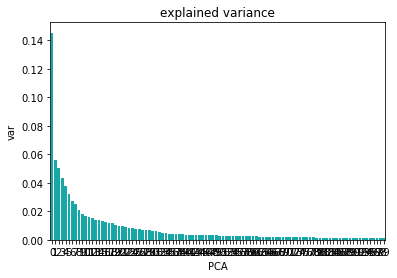

In [17]:
import seaborn as sns
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PCA':range(len(pca.explained_variance_ratio_))})
ax=sns.barplot(x='PCA',y="var", 
           data=df, color="c")
ax.set_title('explained variance')

In [25]:
cum=pd.Series(pca.explained_variance_ratio_).cumsum()
cum
cum[cum<0.7].shape

(34,)